# Pipeline for analysing OCs based on Gaia EDR3 Distances

#### Estimating distances from parallaxes. V: Geometric and photogeometric distances to 1.47 billion stars in Gaia Early Data Release 3
#### Bailer-Jones, C. A. L.; Rybizki, J.; Fouesneau, M. and 2 more

## 1 - Libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import astropy
import astropy.stats as ap
import matplotlib.pyplot as plt
import pyvo as vo

from astropy import units
from astropy.table import Table
from astropy.coordinates import SkyCoord
from IPython.display import display, HTML

## 2 - Constants

In [2]:
svc_url = 'https://dc.zah.uni-heidelberg.de/__system__/tap/run/tap'

query = f'SELECT \
   lite.source_id \
   ,lite.ra \
   ,lite.dec \
   ,lite.pmra \
   ,lite.pmdec \
   ,lite.parallax \
   ,main.r_med_geo \
   ,main.r_med_photogeo \
   ,lite.phot_g_mean_mag \
FROM \
   gaia.edr3lite lite \
   INNER JOIN gedr3dist.main main ON lite.source_id = main.source_id \
WHERE 1=1 \
   AND lite.ruwe < 1.4 '

uns = [['h','m','s'],['d','m','s']]

# Our estimates are quantiles of a posterior probability distribution, so they transform invariably and 
# can therefore also be used directly in the distance modulus (5log10(r)-5).
# The catalogue may be downloaded or queried using ADQL at various sites where it
# can also be cross-matched with the Gaia catalogue.

## 2 - Catalogue access

In [3]:
def query_data(ra, de, rad, mag_lim, pmra_min, pmra_max, pmde_min, pmde_max, dist_lim=None):
    qry = query
    de_hi = de + rad + 0.0001
    de_lo = de - rad - 0.0001
    #if dist_lim:
    #    qry = qry + f' AND main.r_med_geo < {dist_lim}'
    qry = qry + f' AND lite.phot_g_mean_mag < {mag_lim:4.2f}'
    qry = qry + f' AND lite.dec < {de_hi:8.6f}'
    qry = qry + f' AND lite.dec > {de_lo:8.6f}'
    qry = qry + f' AND DISTANCE(lite.ra, lite.dec, {ra:8.6f}, {de:+8.6f}) < {rad:8.6f}'
    tap_service = vo.dal.TAPService(svc_url)
    #resultset = tap_service.search(qry, maxrec=160000)
    resultset = tap_service.run_async(qry, maxrec=160000) # tap_service.hardlimit = 16000000
    df = resultset.to_table().to_pandas()
    df = df.set_index('source_id')
    df = df[df['pmra'] > pmra_min]
    df = df[df['pmra'] < pmra_max]
    df = df[df['pmdec'] > pmde_min]
    df = df[df['pmdec'] < pmde_max]
    df = df.sort_values(by='ra')
    df['dist_mod'] = 5 * np.log10(df['r_med_geo']) - 5
    if dist_lim:
        if dist_lim < 20:
            df = df[df['dist_mod'] < dist_lim]
        else:
            df = df[df['r_med_geo'] < dist_lim]
    #display(df.describe())
    return df

# convert sexagesimal to decimal coordinates
def convert(_ra, _dec, diam):
    comps = list(zip(_ra.split(' '),uns[0]))
    ra = ''.join([item for sublist in comps for item in sublist])
    comps = list(zip(_dec.split(' '),uns[1]))
    dec = ''.join([item for sublist in comps for item in sublist])
    c = SkyCoord(ra, dec, frame='icrs')
    return c.ra.value, c.dec.value, diam / 120

## 3 - VPD scatter plot and 2D Histogram (returning PMs for the bin with highest count)

In [86]:
# Build a VPD (Vector Proper Motion Diagram) scatter plot
def plot_VPD(data, title, pmra_min, pmra_max, pmde_min, pmde_max):
    pmras = data['pmra']
    pmdes = data['pmdec']
    xs, ys = pmras, pmdes
    plt.title(title)
    plt.xlim(pmra_min, pmra_max)
    plt.ylim(pmde_min, pmde_max)
    plt.xlabel('pmRA (mas/yr)')
    plt.ylabel('pmDe (mas/yr)')
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Calculates the median distance modulus of the stars within <limit> of the estimated pms
def calculate_estimates(data, est_pmra, est_pmde, limit = 1.2):
    def filter_pms(pmra, pmde):
        return (abs(est_pmra - pmra) < limit) and (abs(est_pmde - pmde) < limit)
    filter_fn = lambda x: filter_pms(x['pmra'], x['pmdec'])
    data = data[data.apply(filter_fn, axis = 1)]
    dists = data['dist_mod']
    pars = data['parallax']
    pmra = data['pmra']
    pmde = data['pmdec']
    gmag = data['phot_g_mean_mag']
    dist, err_dist = np.median(dists), ap.median_absolute_deviation(dists)
    par,  err_par  = np.median(pars), ap.median_absolute_deviation(pars)
    pmra, err_pmra = np.median(pmra), ap.median_absolute_deviation(pmra)
    pmde, err_pmde = np.median(pmde), ap.median_absolute_deviation(pmde)
    gmin, gmax = np.min(gmag), np.max(gmag)
    return data, dist, err_dist, par, err_par, pmra, err_pmra, pmde, err_pmde, gmin, gmax, len(dists)

# Build 2D histogram for proper motions and returns average PMs for the bin with the highest count
def plot_pm_hist(data, pmra_min, pmra_max, pmde_min, pmde_max, num_bins = 6):
    xs = data['pmra']
    ys = data['pmdec']
    _range = [[pmra_min, pmra_max], [pmde_min, pmde_max]]
    counts, xedges, yedges = np.histogram2d(xs, ys, bins = num_bins, range = _range)
    x_ind, y_ind = np.unravel_index(np.argmax(counts), counts.shape)
    est_pmRA = (xedges[x_ind] + xedges[x_ind+1]) / 2
    est_pmDe = (yedges[y_ind] + yedges[y_ind+1]) / 2
    plt.imshow(counts.T, origin = 'lower')
    plt.xlabel('pmRA bin index')
    plt.ylabel('pmDE bin index')
    plt.plot(x_ind, y_ind, 'or')
    return calculate_estimates(data, est_pmRA, est_pmDe)

# Build G mag X Distance Modulus scatter plot
def plot_mag_par(data):
    dists = data['dist_mod']
    gmags = data['phot_g_mean_mag']
    xs, ys = gmags, dists
    plt.xlabel('G (mag)')
    plt.ylabel('Dist. Mod. (mag)')
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# plot estimates and both graphics side-by-side
def plot_all(data, cl_name, pmra_min, pmra_max, pmde_min, pmde_max):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(131)
    plot_VPD(data, cl_name, pmra_min, pmra_max, pmde_min, pmde_max)
    plt.subplot(132)
    stars, dist_mod, err_dist, par, err_par, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n = plot_pm_hist(data, pmra_min, pmra_max, pmde_min, pmde_max)
    plt.subplot(133)
    plot_mag_par(data)
    plt.tight_layout()
    dist_pc = np.power(10, (dist_mod/5)+1)
    err_dist_pc_upper = np.power(10, ((dist_mod + err_dist)/5)+1) - dist_pc
    err_dist_pc_lower = np.power(10, ((dist_mod - err_dist)/5)+1) - dist_pc
    estimates = f'{cl_name:<20} '
    estimates += f'{dist_pc:6.1f} {err_dist_pc_upper:+4.1f} {err_dist_pc_lower:+4.1f} '
    estimates += f'{dist_mod:7.3f} {err_dist:4.3f} '
    estimates += f'{par:7.3f} {err_par:4.3f} '
    estimates += f'{pmra:7.3f} {err_pmra:4.3f} {pmde:7.3f} {err_pmde:4.3f}'
    estimates += f'{n:>5}  {gmin:5.2f}..{gmax:5.2f}'
    print(estimates)

def process(name, coordinates, diam_arcmin, mag_lim,  pmra_min, pmra_max, pmde_min, pmde_max, dist_lim=None):
    has_minus = '-' in coordinates
    ra_sexa, de_sexa = coordinates.split('-') if has_minus else coordinates.split('+')
    if has_minus:
        de_sexa = '-' + de_sexa
    ra_deg, de_deg, rad_deg = convert(ra_sexa.strip(), de_sexa.strip(), diam_arcmin)
    df = query_data(ra_deg, de_deg, rad_deg, mag_lim, pmra_min, pmra_max, pmde_min, pmde_max, dist_lim)
    plot_all(df, name, pmra_min, pmra_max, pmde_min, pmde_max)

## 4 - Run

Messier 62           6037.4 +1621.5 -1278.2  13.904 0.517   0.152 0.077  -4.815 0.285  -2.923 0.275 1990  11.66..18.00


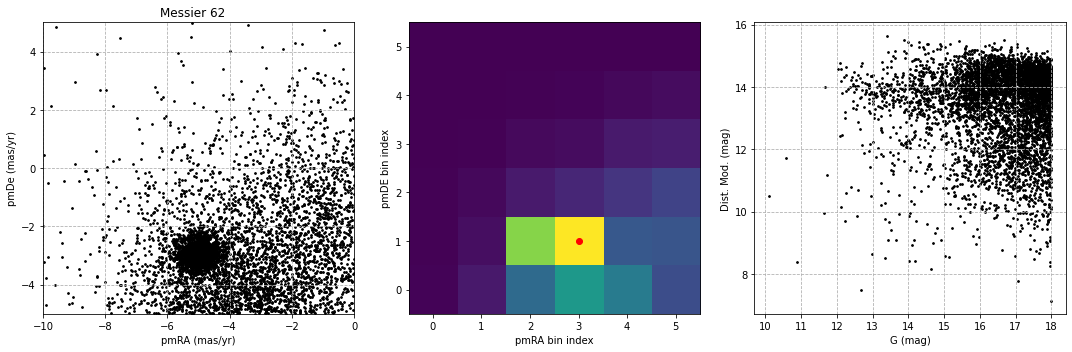

In [87]:
#         name         coord                  dia   mag   pm  dist
#process('Alessi 62', '18 56 06.2 +21 35 49', 36.0,  16,  5,  None) #dist is upper limit in dmod (if < 20) or pc otherwise

process('Messier 62   ', '17 01 07.7 -30 05 38',  25.2, 18, -10, 0, -5, 5, None) # 4572  -5.33   -2.98
#process('Messier 12   ', '16 47 14.4 -01 57 04',  36.0, 21, -10, 0, -4, 4, None) # 6398  -0.16   -6.77
#process('Messier 10   ', '16 57 08.7 -04 05 53',  31.8, 21, -10, 0, -4, 4, None) # 6618  -4.70   -6.53
#process('Messier 107  ', '16 32 32.4 -13 03 25',  27.6, 21, -10, 0, -4, 4, None) # 6757  -1.94   -5.95
#process('HP 1         ', '17 31 05.3 -29 58 55',  15.6, 21, -10, 0, -4, 4, None) # 6930   2.46  -10.14
#process('NGC 6325     ', '17 17 59.1 -23 46 00',  12.0, 21, -10, 0, -4, 4, None) # 6988  -8.38   -9.01
#process('Palomar 6    ', '17 43 42.2 -26 13 23',  12.0, 21, -10, 0, -4, 4, None) # 7920  -9.26   -5.33
#process('NGC 6355     ', '17 23 58.6 -26 21 11',  10.8, 21, -10, 0, -4, 4, None) # 8650  -4.66   -0.52
#process('NGC 6401     ', '17 38 37.9 -23 55 02',  16.8, 21, -10, 0, -4, 4, None) # 8651  -2.82    1.44
#process('NGC 6304     ', '17 14 32.9 -29 28 54',  15.6, 21, -10, 0, -4, 4, None) # 9285  -3.95   -1.12
#process('NGC 6287     ', '17 05 09.2 -22 43 06',  20.4, 21, -10, 0, -4, 4, None) # 9311  -4.89   -1.92
#process('NGC 6342     ', '17 21 11.6 -19 36 18',  24.6, 21, -10, 0, -4, 4, None) #10277  -2.95   -7.01
#process('Messier 9    ', '17 19 12.5 -18 30 53',  23.4, 21, -10, 0, -4, 4, None) #10707  -2.20   -3.21
#process('Messier 19   ', '17 02 37.5 -26 16 11',  25.2, 21, -10, 0, -4, 4, None) #10823  -3.22    1.61
#process('NGC 6356     ', '17 23 33.6 -17 48 46',  20.4, 21, -10, 0, -4, 4, None) #12642  -3.77   -3.37
#process('NGC 6293     ', '17 10 09.9 -26 34 48',  18.6, 21, -10, 0, -4, 4, None) #14368   0.82   -4.31
#process('NGC 6316     ', '17 16 36.8 -28 09 12',  14.4, 21, -10, 0, -4, 4, None) #15175  -4.82   -4.61
#process('NGC 6539     ', '18 04 46.2 -07 35 23',  22.8, 21, -10, 0, -4, 4, None) #15873  -6.83   -3.48
#process('NGC 6235     ', '16 53 25.4 -22 10 47',  18.0, 21, -10, 0, -4, 4, None) #16181  -3.94   -7.56
#process('Messier 14   ', '17 37 35.6 -03 14 50',  36.0, 21, -10, 0, -4, 4, None) #18657  -3.61   -5.04
#process('NGC 6426     ', '17 44 54.7 +03 10 12',  21.6, 21, -10, 0, -4, 4, None) #19740  -1.86   -2.99
#process('NGC 6284     ', '17 04 28.5 -24 45 58',  25.2, 21, -10, 0, -4, 4, None) #20040  -3.19   -2.05
#process('IC 1257      ', '17 27 08.4 -07 05 35',  13.2, 21, -10, 0, -4, 4, None) #27770  -0.93   -1.41
#process('Palomar 15   ', '16 59 51.1 -00 32 20',   8.4, 21, -10, 0, -4, 4, None) #45100  -0.58   -0.86
#process('NGC 6517     ', '18 01 48.7 -08 57 24',  19.2, 21, -10, 0, -4, 4, None) #46083  -1.52   -4.26